In [1]:
import keras
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model # new!
from keras.layers import Input, concatenate # new!
from keras.layers import Dense, Dropout, Embedding, SpatialDropout1D, Conv1D, GlobalMaxPooling1D
from keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# output directory name:
output_dir = 'model_output/multiconv'

# training:
epochs = 4
batch_size = 128

# vector-space embedding:
n_dim = 64
n_unique_words = 5000
max_review_length = 400
pad_type = trunc_type = 'pre'
drop_embed = 0.2

# convolutional layer architecture:
n_conv_1 = n_conv_2 = n_conv_3 = 256
k_conv_1 = 3
k_conv_2 = 2
k_conv_3 = 4

# dense layer architecture:
n_dense = 256
dropout = 0.2


In [3]:
(x_train, y_train), (x_valid, y_valid) = imdb.load_data(num_words=n_unique_words)

# pre process
x_train = pad_sequences(x_train, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)
x_valid = pad_sequences(x_valid, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### Architecture

In [4]:
input_layer = Input(shape=(max_review_length,),
                    dtype='int16', name='input')
# accommodate the maximum index of the words

# embedding:
embedding_layer = Embedding(n_unique_words, n_dim,
                            name='embedding')(input_layer)
drop_embed_layer = SpatialDropout1D(drop_embed,
                                    name='drop_embed')(embedding_layer)

# three parallel convolutional streams:
conv_1 = Conv1D(n_conv_1, k_conv_1,
                activation='relu', name='conv_1')(drop_embed_layer)
maxp_1 = GlobalMaxPooling1D(name='maxp_1')(conv_1)

conv_2 = Conv1D(n_conv_2, k_conv_2,
                activation='relu', name='conv_2')(drop_embed_layer)
maxp_2 = GlobalMaxPooling1D(name='maxp_2')(conv_2)

conv_3 = Conv1D(n_conv_3, k_conv_3,
                activation='relu', name='conv_3')(drop_embed_layer)
maxp_3 = GlobalMaxPooling1D(name='maxp_3')(conv_3)

# concatenate the activations from the three streams:
concat = concatenate([maxp_1, maxp_2, maxp_3])

# dense hidden layers:
dense_layer = Dense(n_dense,
                    activation='relu', name='dense')(concat)
drop_dense_layer = Dropout(dropout, name='drop_dense')(dense_layer)
dense_2 = Dense(int(n_dense/4),
                activation='relu', name='dense_2')(drop_dense_layer)
dropout_2 = Dropout(dropout, name='drop_dense_2')(dense_2)

# sigmoid output layer:
predictions = Dense(1, activation='sigmoid', name='output')(dropout_2)

# create model:
model = Model(input_layer, predictions)


In [5]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 400)       │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 400, 64)   │    320,000 │ input[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ drop_embed          │ (None, 400, 64)   │          0 │ embedding[0][0]   │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_1 (Conv1D)     │ (None, 398, 256)  │     49,408 │ drop_embed[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_2 (Conv1D)     │ (None, 399, 256)  │     33,024 │ drop_embed[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_3 (Conv1D)     │ (None, 397, 256)  │     65,792 │ drop_embed[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ maxp_1              │ (None, 256)       │          0 │ conv_1[0][0]      │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ maxp_2              │ (None, 256)       │          0 │ conv_2[0][0]      │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ maxp_3              │ (None, 256)       │          0 │ conv_3[0][0]      │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 768)       │          0 │ maxp_1[0][0],     │
│ (Concatenate)       │                   │            │ maxp_2[0][0],     │
│                     │                   │            │ maxp_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    196,864 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ drop_dense          │ (None, 256)       │          0 │ dense[0][0]       │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │     16,448 │ drop_dense[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ drop_dense_2        │ (None, 64)        │          0 │ dense_2[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │         65 │ drop_dense_2[0][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 681,601 (2.60 MB)

 Trainable params: 681,601 (2.60 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.keras")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)


In [8]:
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_valid, y_valid), callbacks=[modelcheckpoint])

Epoch 1/4
196/196 ━━━━━━━━━━━━━━━━━━━━ 302s 2s/step - accuracy: 0.6042 - loss: 0.6195 - val_accuracy: 0.8440 - val_loss: 0.3555
Epoch 2/4
196/196 ━━━━━━━━━━━━━━━━━━━━ 326s 2s/step - accuracy: 0.8923 - loss: 0.2709 - val_accuracy: 0.8931 - val_loss: 0.2607
Epoch 3/4
196/196 ━━━━━━━━━━━━━━━━━━━━ 323s 2s/step - accuracy: 0.9369 - loss: 0.1778 - val_accuracy: 0.8954 - val_loss: 0.2622
Epoch 4/4
196/196 ━━━━━━━━━━━━━━━━━━━━ 320s 2s/step - accuracy: 0.9607 - loss: 0.1183 - val_accuracy: 0.8912 - val_loss: 0.3003


### Evaluate

In [9]:
model.load_weights(output_dir+"/weights.02.keras")

y_hat = model.predict(x_valid)

782/782 ━━━━━━━━━━━━━━━━━━━━ 55s 70ms/step


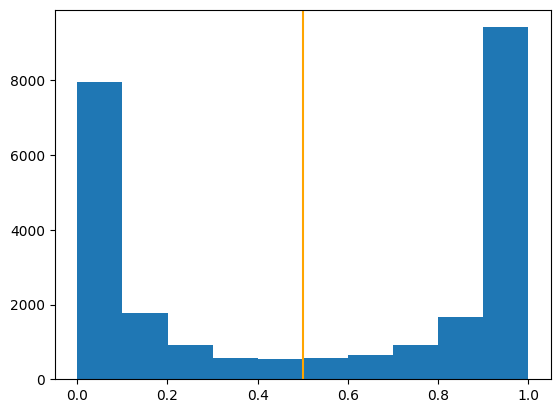

In [10]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [11]:
"{:0.2f}".format(roc_auc_score(y_valid, y_hat)*100.0)

'96.06'